In [3]:
import numpy as np, matplotlib.pyplot as plt
H, W = 800, 1600
img = np.ones((H, W, 3), float)
def add_band(y0, y1, color):
    y = np.linspace(0, H-1, H)
    mask = (y[:, None] >= y0) & (y[:, None] <= y1)
    blur = np.exp(-((y[:, None] - (y0+y1)/2)/(0.12*(y1-y0)))**2)
    for c in range(3):
        img[..., c] = np.where(mask, color[c]/255.0*blur + (1-blur)*img[..., c], img[..., c])

add_band(int(0.22*H), int(0.35*H), (220, 60, 60))   # red
add_band(int(0.45*H), int(0.58*H), (60, 180, 75))   # green
add_band(int(0.68*H), int(0.81*H), (60, 120, 220))  # blue

plt.imsave("init_image.png", np.clip(img,0,1))
"init_image.png"

'init_image.png'

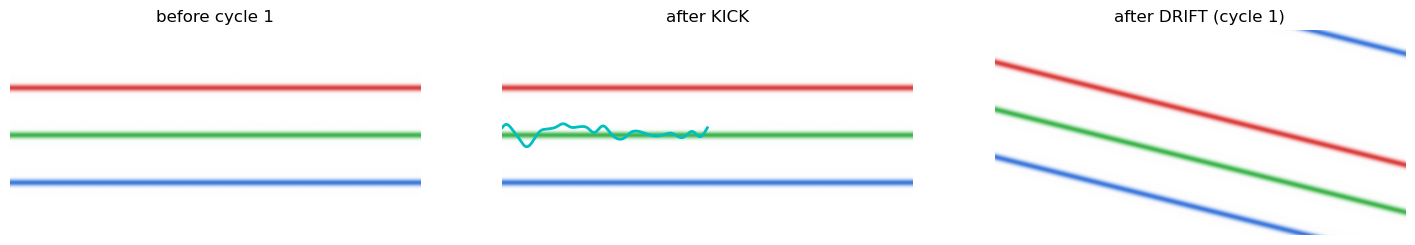

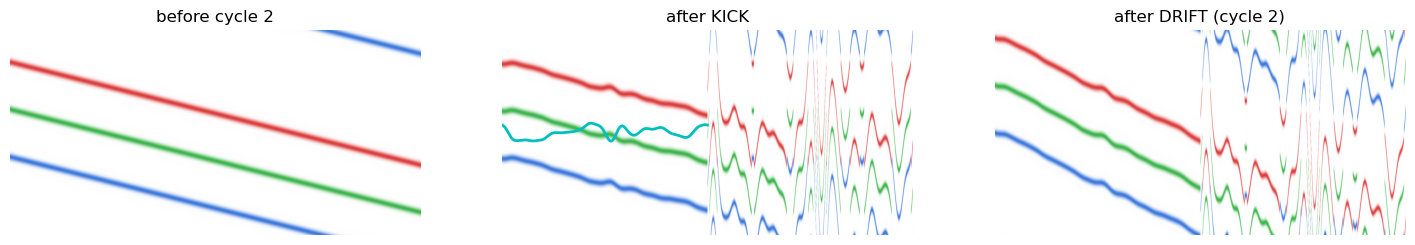

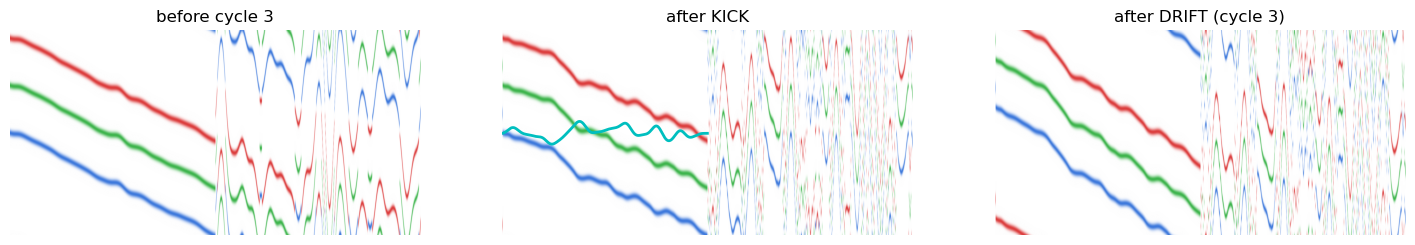

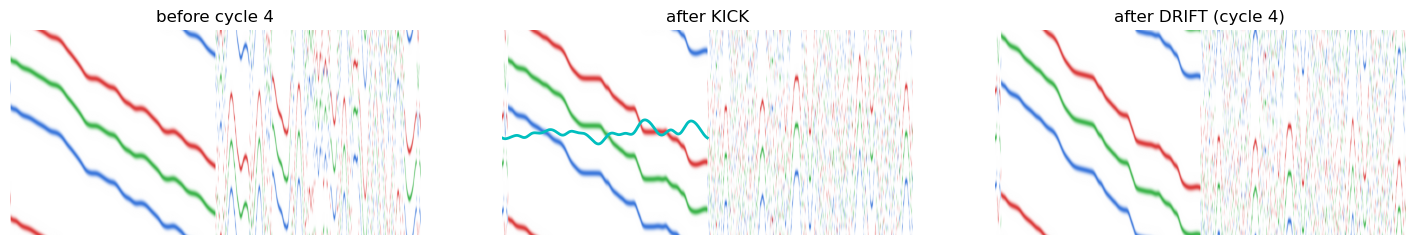

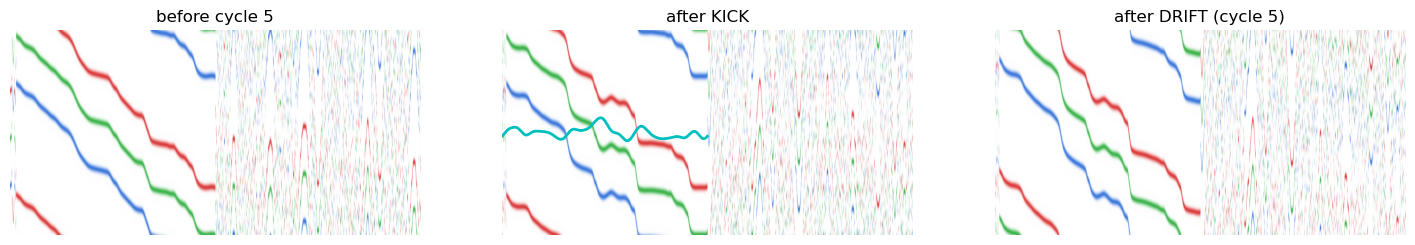

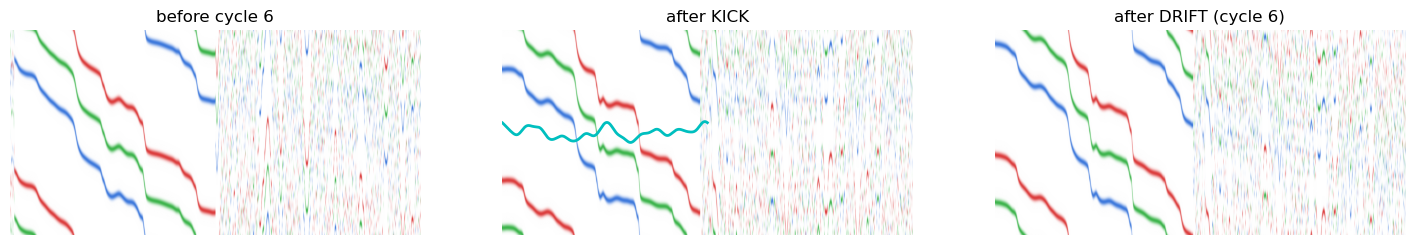

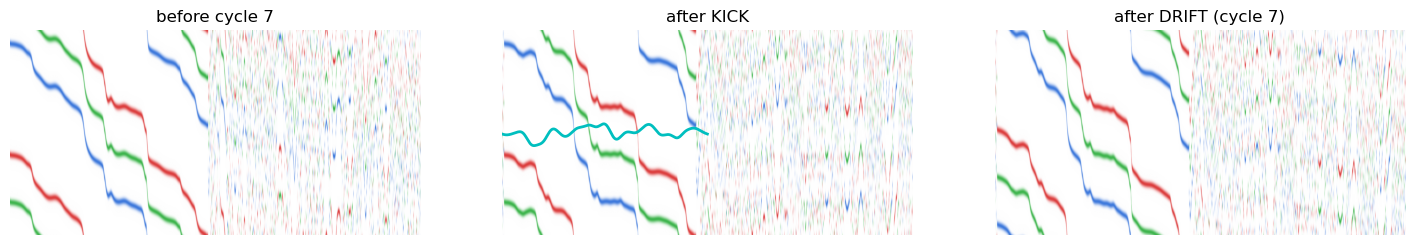

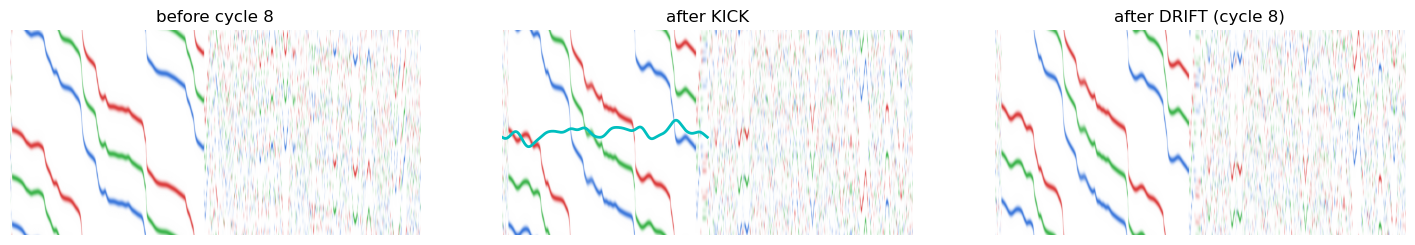

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp
from skimage.io import imread

rng = np.random.default_rng(0)
def randpot1d_getFFT(c):
    f = np.fft.fft(np.fft.ifftshift(c))
    return np.sqrt(np.abs(f)).astype(np.complex128)

def randpot1d_four(cf):
    n = cf.shape[0]
    p = (2*rng.random(n//2-1)-1)*np.pi
    phase = np.zeros(n)
    phase[1:n//2] = p
    phase[n//2+1:] = -p[::-1]
    cff = cf * np.exp(1j*phase)
    cff[0] = 0
    u = np.sqrt(n) * np.fft.ifft(cff)
    u = np.real(u)
    return u / np.std(u)  # unit-variance

def InverseKick(coords, cf, K):
    global dp
    R = np.array(coords)        
    X = R[:, 0]                 
    dp = K * randpot1d_four(cf) 
    Rp = R.copy()
    ix = np.floor(X).astype(int) % dp.shape[0]
    Rp[:,1] = Rp[:,1]           
    Rp[:,0] = Rp[:,0] - (dp[ix] + (dp[(ix+1)%dp.size]-dp[ix])*(X-ix))
    return Rp

def InverseDrift(coords, row0, Tau):
    R = np.array(coords)
    Rp = R.copy()
    Rp[:,1] = Rp[:,1] - (Rp[:,0] - row0) * Tau
    return Rp

cycles = 8         
image = imread("init_image.png").astype(float)/255.0
rows, cols = image.shape[:2]
if rows % 2:  image = image[1:,:,:]
if cols % 2:  image = image[:,1:,:]
rows, cols = image.shape[:2]
row0 = rows/2.0         
lc = 0.05                 
K0 = 0.025               
Tau0 = 0.5               
Lx = 1.0; Lp = 1.0
K   = K0/float(Lp)*rows
Tau = float(Tau0*Lx*rows)/(cols*Lp)
x = np.linspace(-Lx/2, Lx/2, rows, endpoint=True)
c = np.exp(-x**2/lc**2)
cf = randpot1d_getFFT(c)

#iterate 
cur = image.copy()
figlist = []
for it in range(cycles):
    stage1 = warp(cur, InverseKick, map_args={'cf': cf, 'K': K}, mode='wrap', order=1, preserve_range=True) #kick
    stage2 = warp(stage1, InverseDrift, map_args={'row0': row0, 'Tau': Tau}, mode='wrap', order=1, preserve_range=True)#drift
    # inside the for-it loop, after computing stage2:
    if it == 0: x_densities = []
    g = 0.2126*stage2[...,0] + 0.7152*stage2[...,1] + 0.0722*stage2[...,2]
    x_densities.append(g.mean(axis=0))

    f, (p1, p2, p3) = plt.subplots(1, 3, figsize=(18,6), sharey=True)
    for ax in (p1,p2,p3):
        ax.axis('off'); ax.set_aspect('equal')
    p1.imshow(cur);    p1.set_title('before cycle {}'.format(it+1))
    p2.imshow(stage1); p2.set_title('after KICK')
    try: p2.plot(rows/2 + dp, color='c', linewidth=2)
    except NameError: pass
    p3.imshow(stage2); p3.set_title('after DRIFT (cycle {})'.format(it+1))
    plt.show()

    cur = stage2

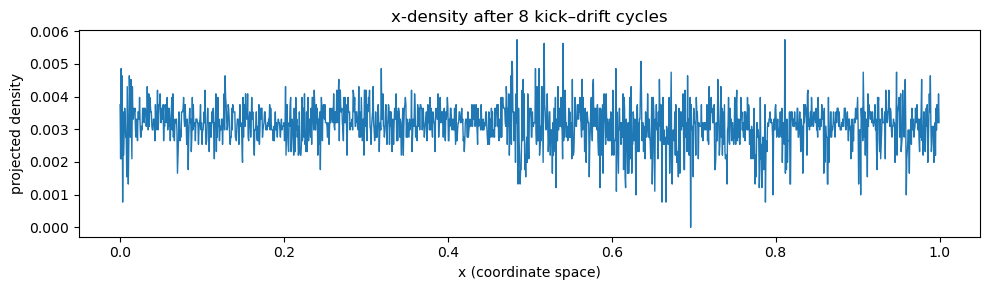

In [7]:
import numpy as np
import matplotlib.pyplot as plt
rows, cols = cur.shape[:2]
gray = 0.2126*cur[...,0] + 0.7152*cur[...,1] + 0.0722*cur[...,2]
x_density = gray.mean(axis=0)          
x_density = (x_density - x_density.min()) / (x_density.ptp() + 1e-12)
x = np.linspace(0.0, 1.0, cols, endpoint=False)

plt.figure(figsize=(10,3))
plt.plot(x, x_density, lw=1)
plt.xlabel("x (coordinate space)")
plt.ylabel("projected density")
plt.title(f"x-density after {cycles} kick–drift cycles")
plt.tight_layout()
plt.show()

# (optional) save to file
plt.figure(figsize=(10,3))
plt.plot(x, x_density, lw=1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("x_density_projection.png", dpi=150, bbox_inches="tight")
plt.close()

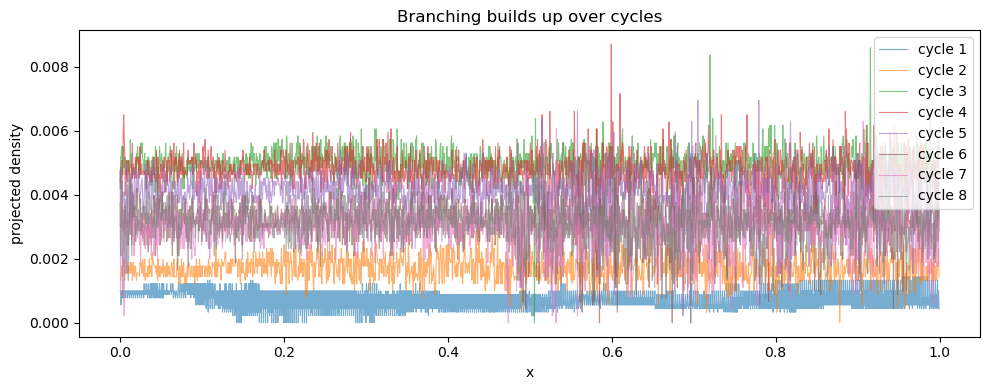

In [9]:
plt.figure(figsize=(10,4))
for k, xd in enumerate(x_densities):
    xd = (xd - xd.min())/(xd.ptp()+1e-12)
    plt.plot(np.linspace(0,1,len(xd),endpoint=False), xd, lw=0.8, alpha=0.6, label=f"cycle {k+1}")
plt.legend()
plt.xlabel("x")
plt.ylabel("projected density")
plt.title("Branching builds up over cycles")
plt.tight_layout()
plt.show()